# Estación Escuelas Aguirre

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [4]:
df = pd.read_csv("../data/df_8.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,NO2
month,
2013-01-01,33.516129
2013-02-01,40.290323
2013-03-01,36.548387
2013-04-01,31.548387
2013-05-01,32.612903


### Estacionalidad

In [6]:
df2 = df.copy()

In [7]:
df2["año"] = df.index.year
df2["mes"] = df.index.month

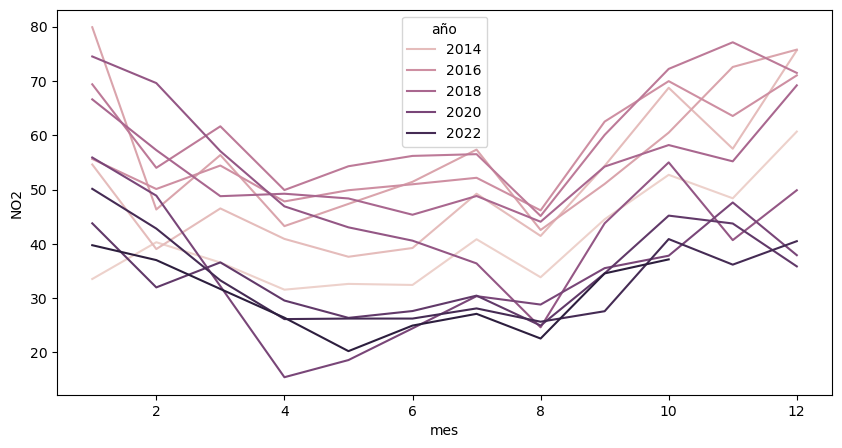

In [8]:
sns.lineplot(x = "mes", y = "NO2", hue = "año", data = df2);

### Estacionaridad

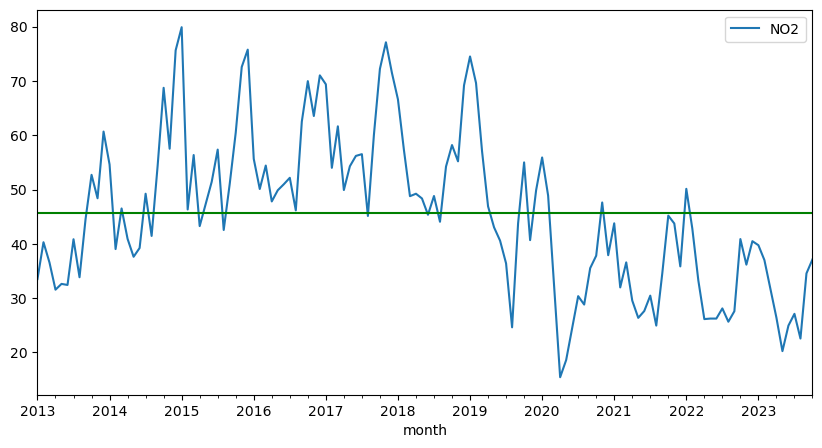

In [9]:
df.plot()
plt.axhline(df.NO2.mean(), c = "g");

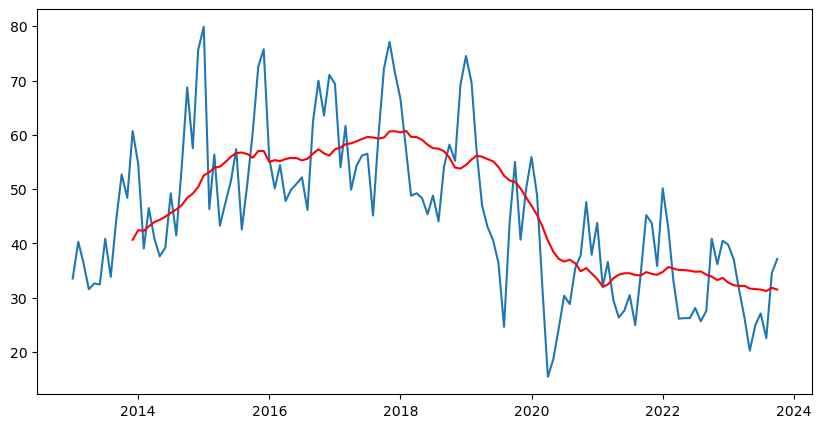

In [10]:
plt.plot(df["NO2"])
plt.plot(df.rolling(window= 12).mean(), c = "r");

### Test de Fuller

In [11]:
res = adfuller(df["NO2"])
res

(-0.2012371021821616,
 0.9383739974093172,
 12,
 117,
 {'1%': -3.487517288664615,
  '5%': -2.8865777180380032,
  '10%': -2.5801239192052012},
 802.7769509977652)

In [12]:
print("AD Fuller Stats", res[0])
print("p-value", res[1])
print("Critical values")

for k, v in res[4].items():
    print(k, round(v, 2))

AD Fuller Stats -0.2012371021821616
p-value 0.9383739974093172
Critical values
1% -3.49
5% -2.89
10% -2.58


*Me salen datos no estacionarios. Su media y su varianza están en función del tiempo 🍋*

### Autocorrelación

In [13]:
for i in range(49):
    print(f"{i} mes Lag, {df['NO2'].autocorr(lag= i)}")

0 mes Lag, 1.0
1 mes Lag, 0.8082887471176501
2 mes Lag, 0.6647100395174458
3 mes Lag, 0.5575283227256663
4 mes Lag, 0.4022040231587039
5 mes Lag, 0.29813383064128707
6 mes Lag, 0.2689423906219966
7 mes Lag, 0.24592239890908948
8 mes Lag, 0.3322323506654369
9 mes Lag, 0.47282023792303174
10 mes Lag, 0.5739219859067247
11 mes Lag, 0.6583632325433614
12 mes Lag, 0.7502312217125138
13 mes Lag, 0.6502973250847497
14 mes Lag, 0.52831098590691
15 mes Lag, 0.398332045839298
16 mes Lag, 0.232424173243492
17 mes Lag, 0.12197887097778973
18 mes Lag, 0.08301939364094789
19 mes Lag, 0.05795463748595119
20 mes Lag, 0.12258745575358196
21 mes Lag, 0.23006234097997433
22 mes Lag, 0.33555039648317625
23 mes Lag, 0.4595750636552664
24 mes Lag, 0.563999861598662
25 mes Lag, 0.4802703789507753
26 mes Lag, 0.3593050093407961
27 mes Lag, 0.24646198396792007
28 mes Lag, 0.08045378554208858
29 mes Lag, -0.0651265390632459
30 mes Lag, -0.12697489760881533
31 mes Lag, -0.1455218714025654
32 mes Lag, -0.07803402

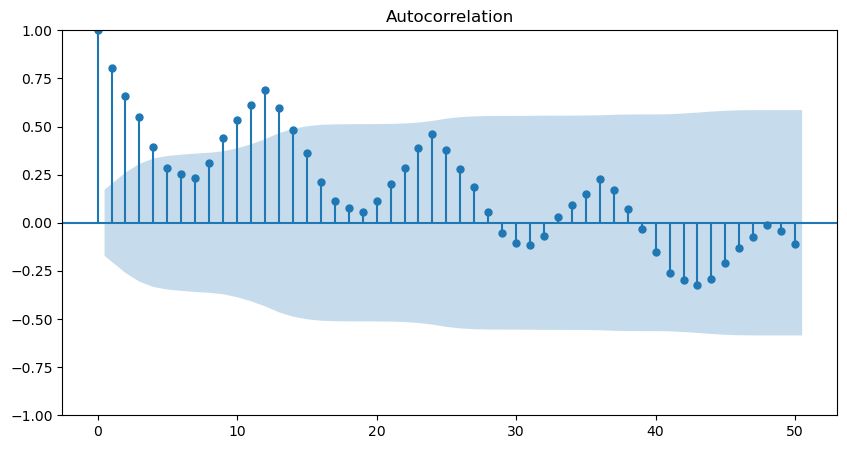

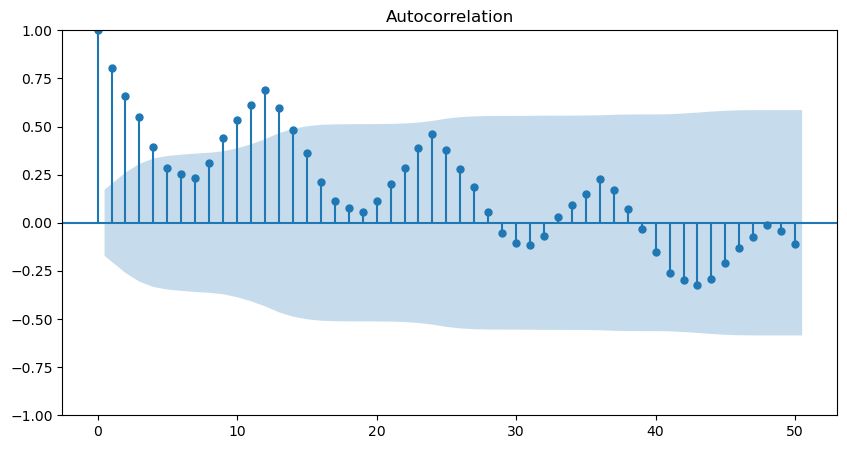

In [14]:
plot_acf(df, lags = 50)

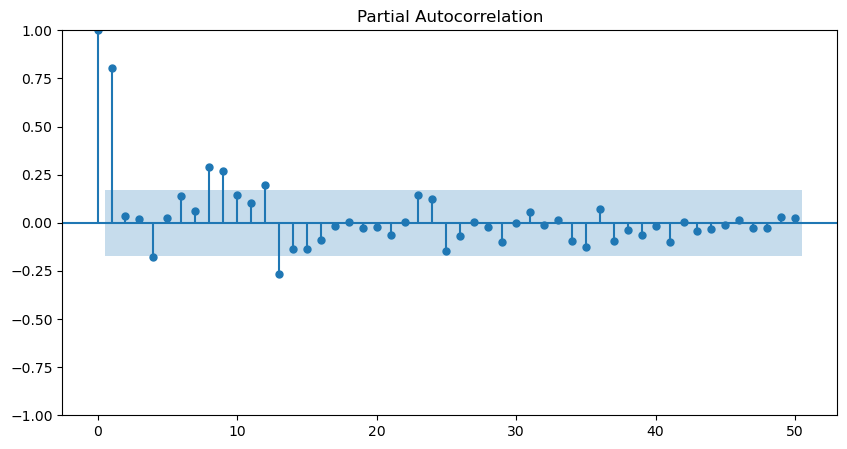

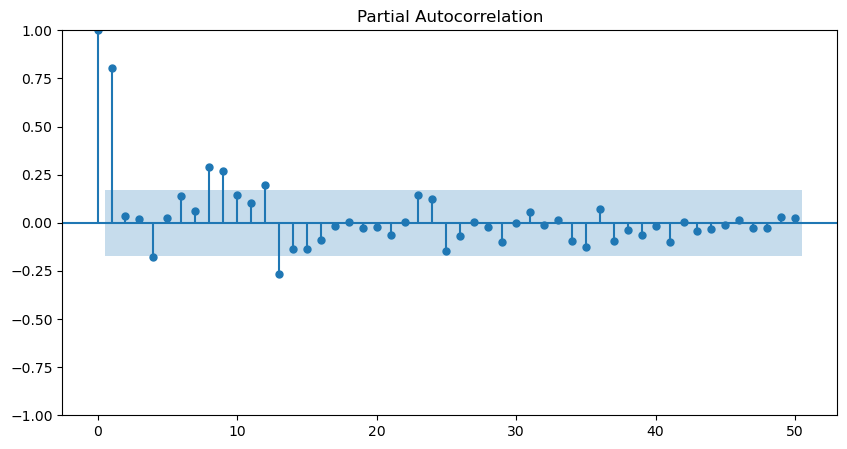

In [15]:
plot_pacf(df, lags = 50)

In [16]:
df.head()

,NO2
month,
2013-01-01,33.516129
2013-02-01,40.290323
2013-03-01,36.548387
2013-04-01,31.548387
2013-05-01,32.612903


In [17]:
df.shape

(130, 1)

In [18]:
df.isnull().sum()

NO2    0
dtype: int64

In [19]:
df.dtypes

NO2    float64
dtype: object

## SARIMA

In [20]:
y_test = df["NO2"][-30:]
y_train = df["NO2"][:-30]

In [21]:
ps = range(6)
ds = range(1,3)
qs = range(3)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2)]


In [22]:
%%time

modelo=SARIMAX(endog=y_train, 
               exog=None,
               #order=(4, 1, 5),  # modelo arima
               seasonal_order=(6, 1, 3, 12) # modelo sarima, estacionalidad es el ultimo
              ).fit(disp=False)
                     
pred=modelo.predict(len(y_train), len(df)-1)  

error=(pred-y_test).abs().sum()/len(pred) 
print ('Error mae: ', error)


res=pd.DataFrame({'real':y_test, 'pred':pred, 'error':pred-y_test})
res

C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error mae:  13.826663566061146
CPU times: total: 4.38 s
Wall time: 20.5 s


,real,pred,error
2021-05-01,26.354839,28.596607,2.241769
2021-06-01,27.612903,30.363727,2.750824
2021-07-01,30.451613,37.262668,6.811055
2021-08-01,24.935484,33.415552,8.480068
2021-09-01,34.548387,45.555386,11.006999
2021-10-01,45.193548,53.338380,8.144831
2021-11-01,43.741935,44.601953,0.860017
2021-12-01,35.838710,56.183174,20.344464
2022-01-01,50.129032,62.790801,12.661769
2022-02-01,42.806452,44.671961,1.865509


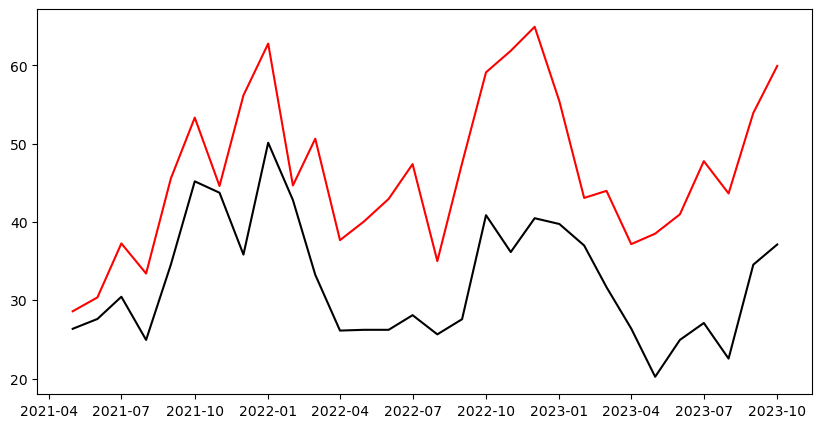

In [23]:
plt.plot(res["pred"], c = "r")
plt.plot(res["real"], c = "black");

In [24]:
pred_año = pd.DataFrame(modelo.predict(start = len(df), end = len(df) + 12))
pred_año

,predicted_mean
2023-11-01,59.289934
2023-12-01,66.970002
2024-01-01,67.791076
2024-02-01,50.627488
2024-03-01,59.356471
2024-04-01,49.170682
2024-05-01,50.951526
2024-06-01,51.899941
2024-07-01,52.873661
2024-08-01,40.141717


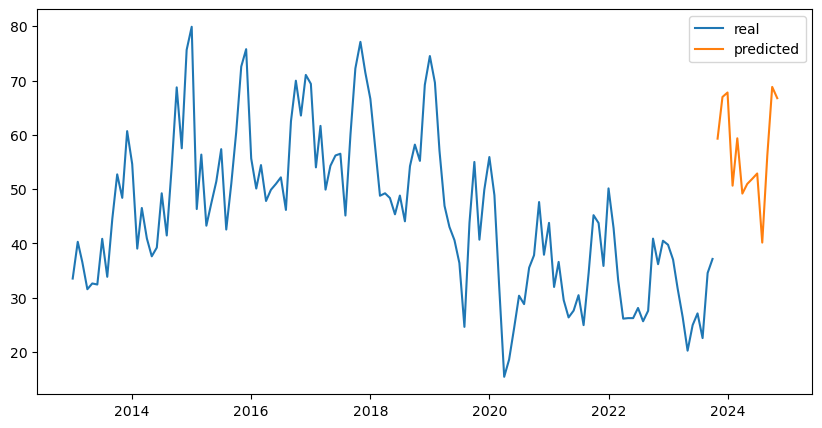

In [25]:
plt.plot(df)
plt.plot(pred_año)
plt.legend(["real", "predicted"]);

In [28]:
pred_año.mean()

predicted_mean    56.98691
dtype: float64